Data loaded: 100000 rows, 54 columns

Candidate features present in data: 52

DATA SUMMARY (selected):
                        count unique  top freq         mean          std  \
annual_medical_cost  100000.0    NaN  NaN  NaN  3009.451907  3127.462822   
cancer_history       100000.0    NaN  NaN  NaN      0.02151     0.145078   
kidney_disease       100000.0    NaN  NaN  NaN      0.01462     0.120027   
liver_disease        100000.0    NaN  NaN  NaN      0.01477     0.120632   
arthritis            100000.0    NaN  NaN  NaN      0.10831     0.310773   
mental_health        100000.0    NaN  NaN  NaN      0.13014     0.336459   
proc_imaging_count   100000.0    NaN  NaN  NaN      0.50853     0.749755   
proc_surgery_count   100000.0    NaN  NaN  NaN      0.15869     0.463562   
proc_physio_count    100000.0    NaN  NaN  NaN      0.50839     0.747218   
proc_consult_count   100000.0    NaN  NaN  NaN      0.50933      0.75363   

                       min        25%       50%        75%  

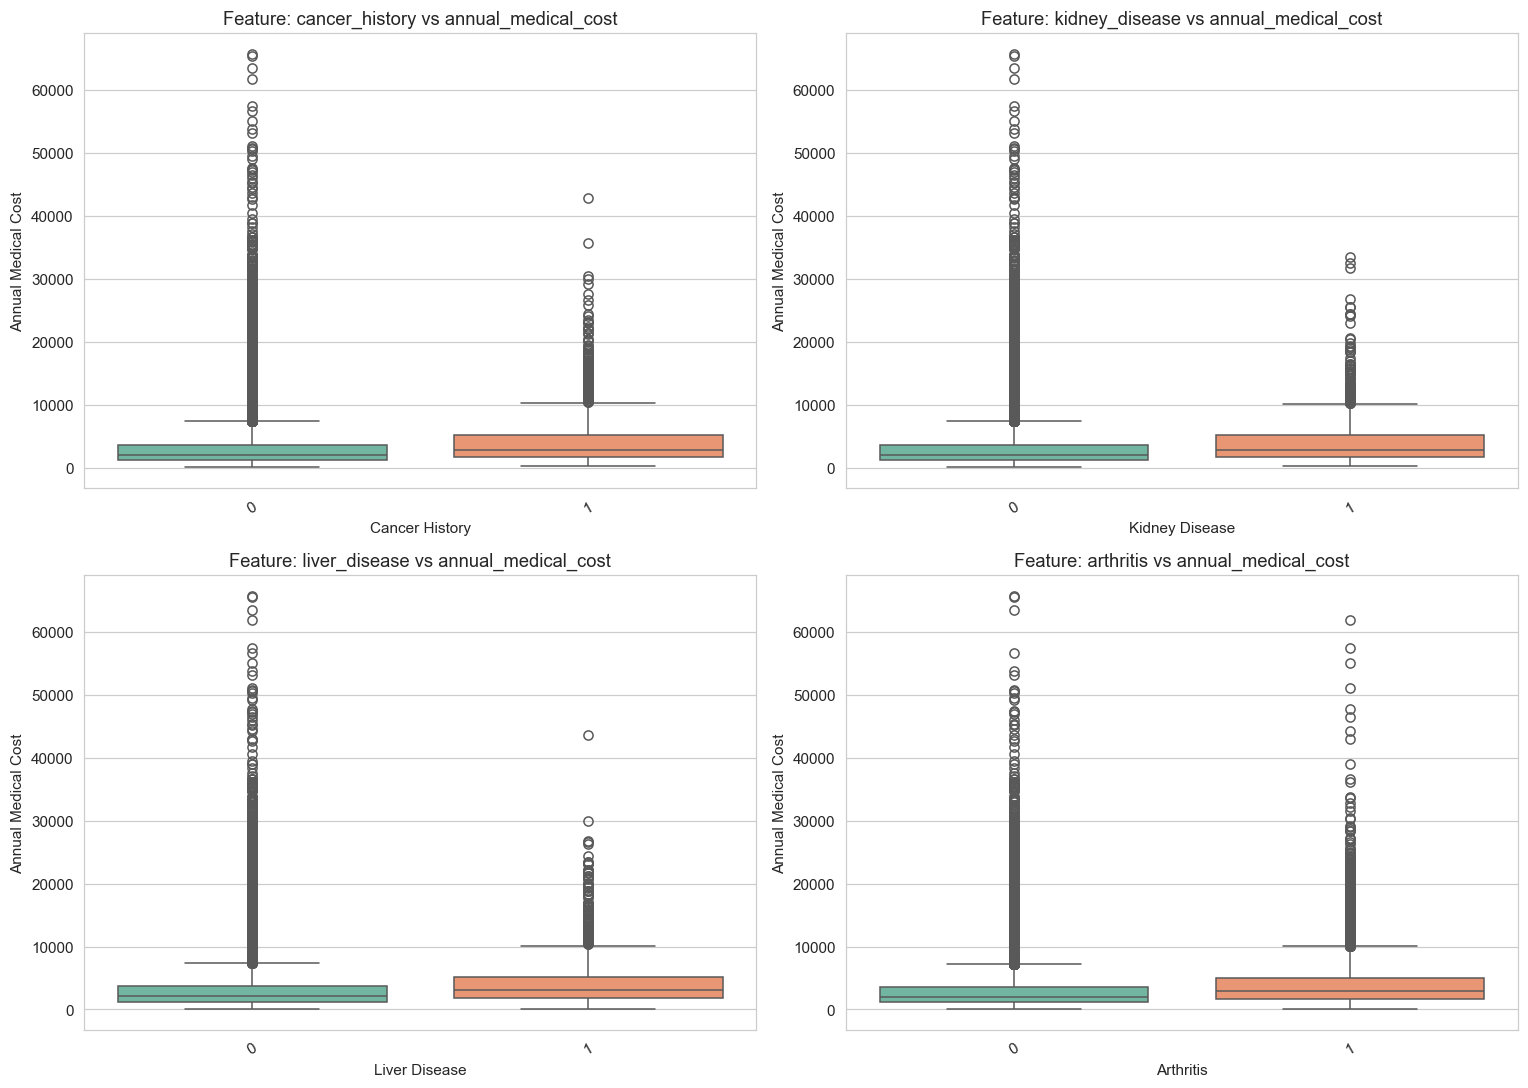

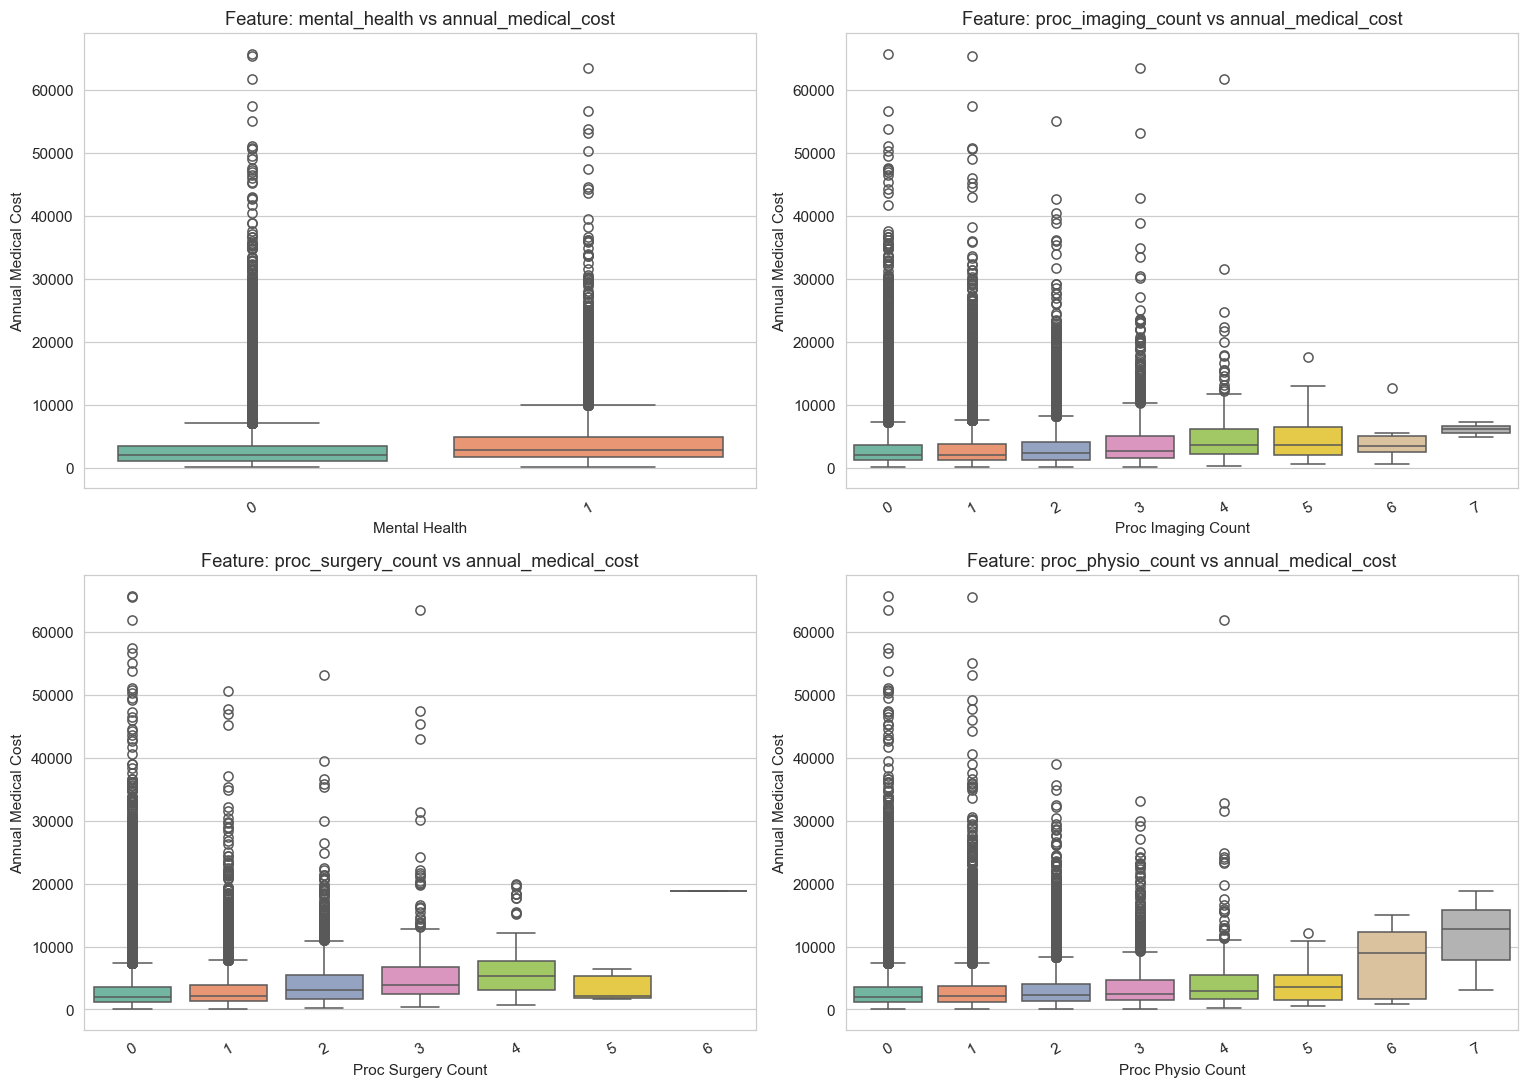

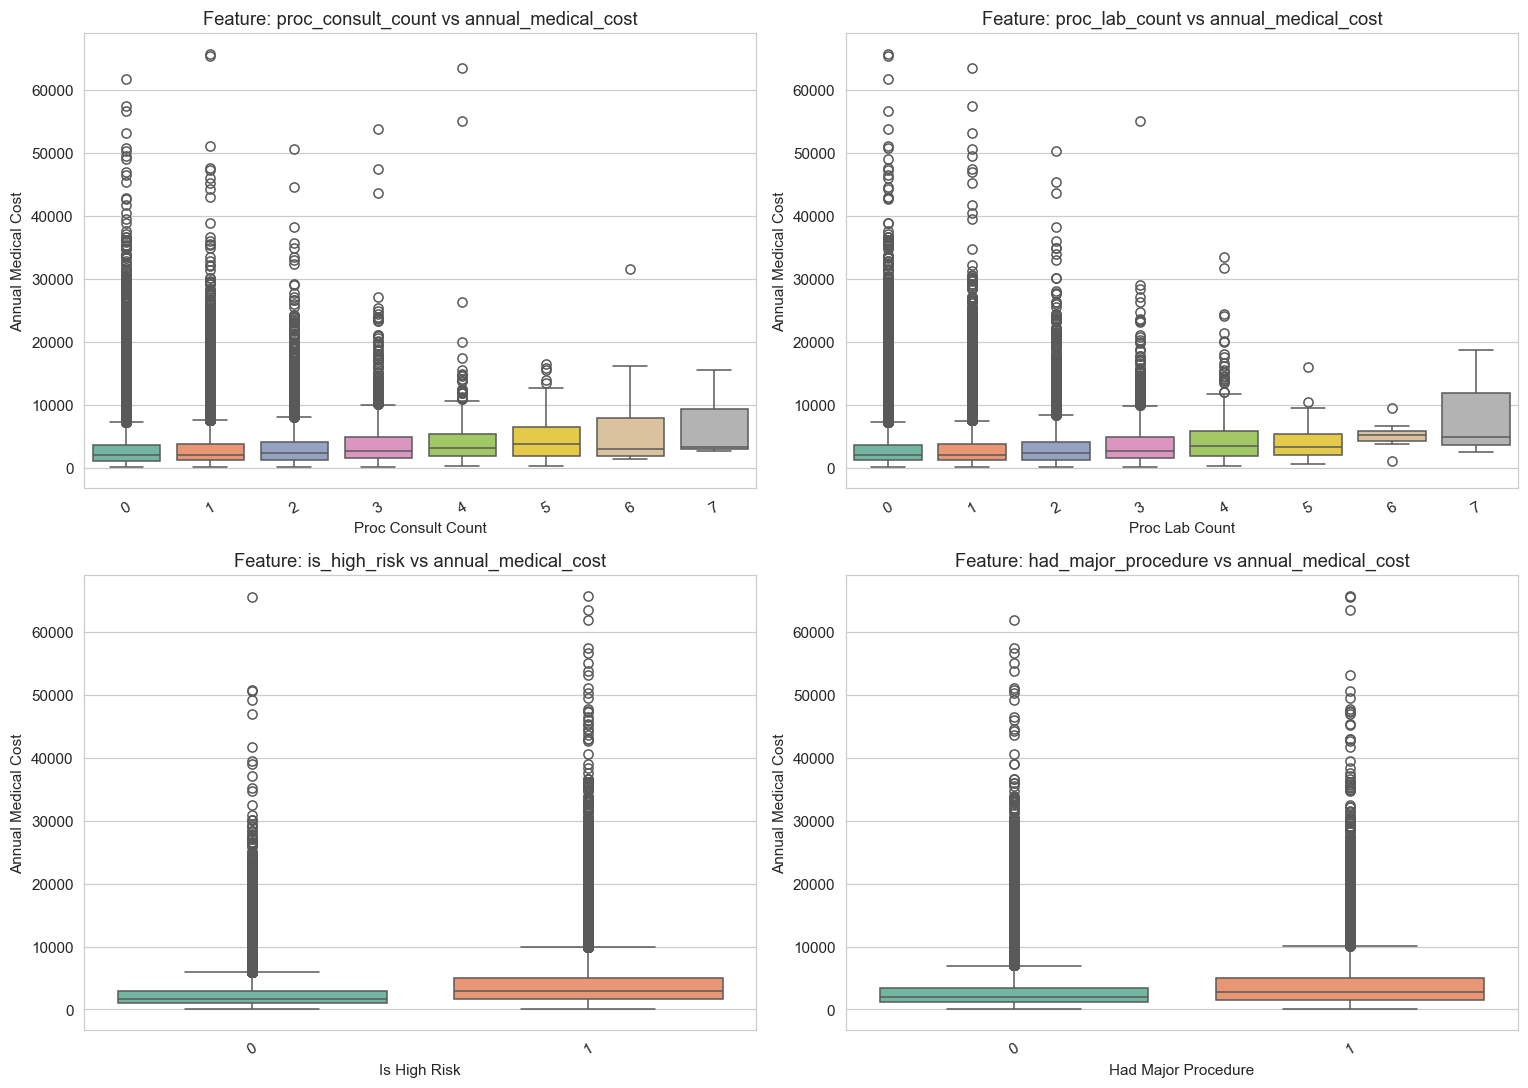

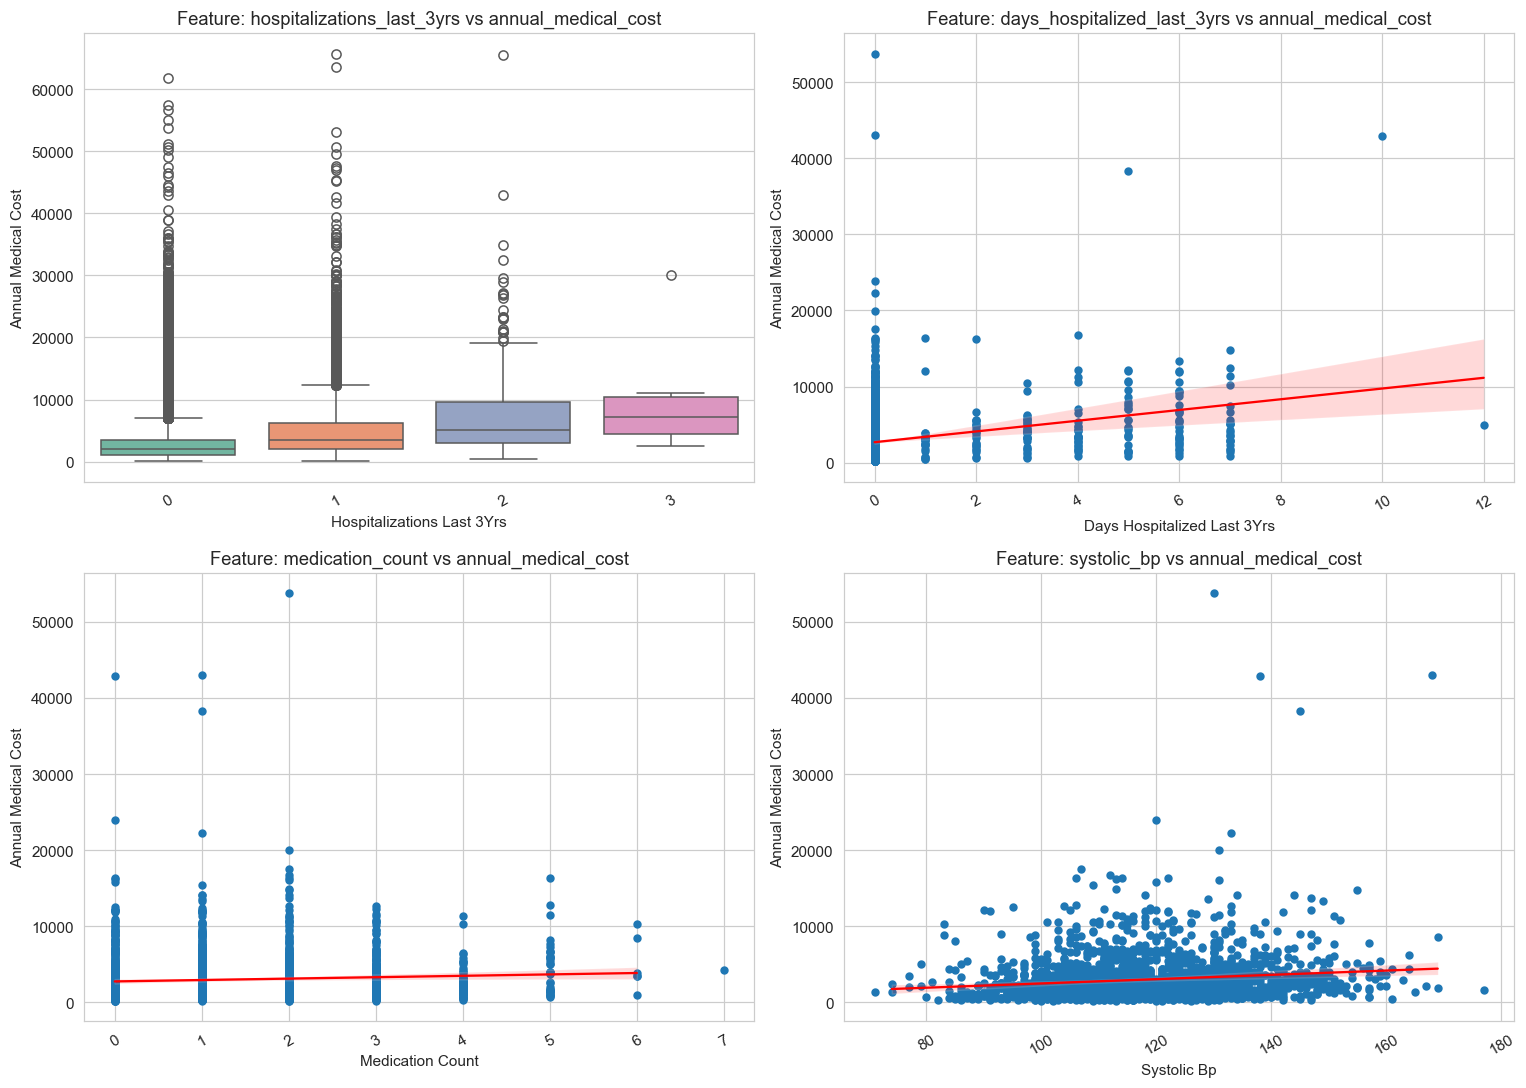

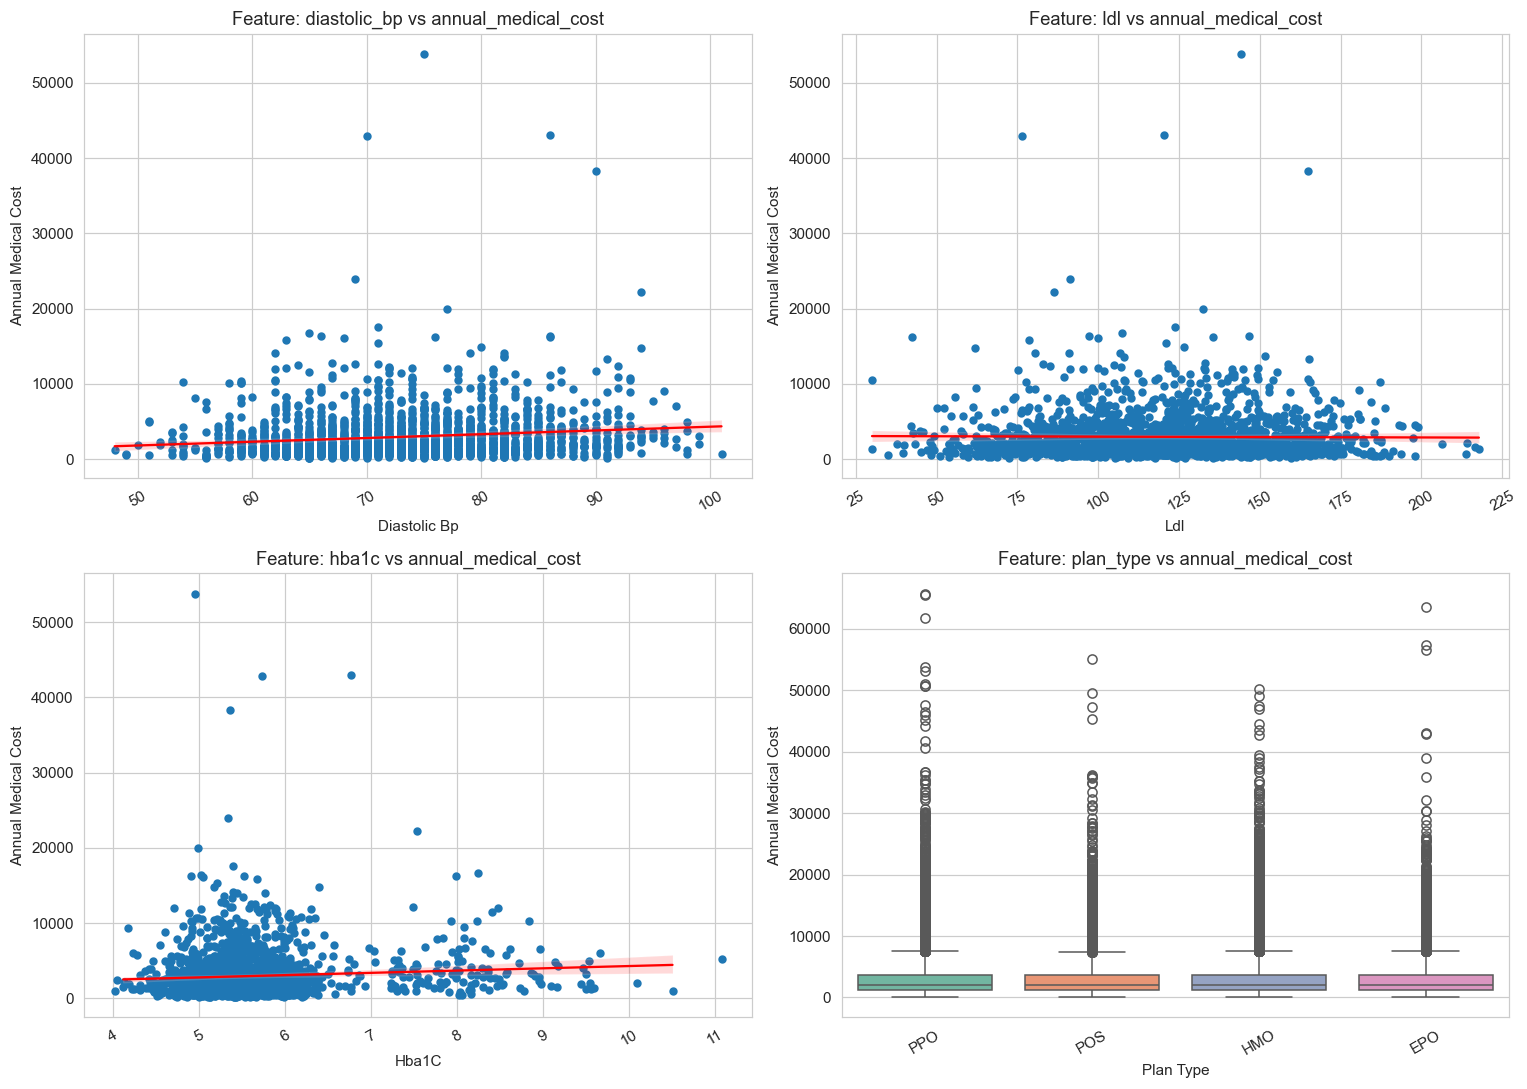

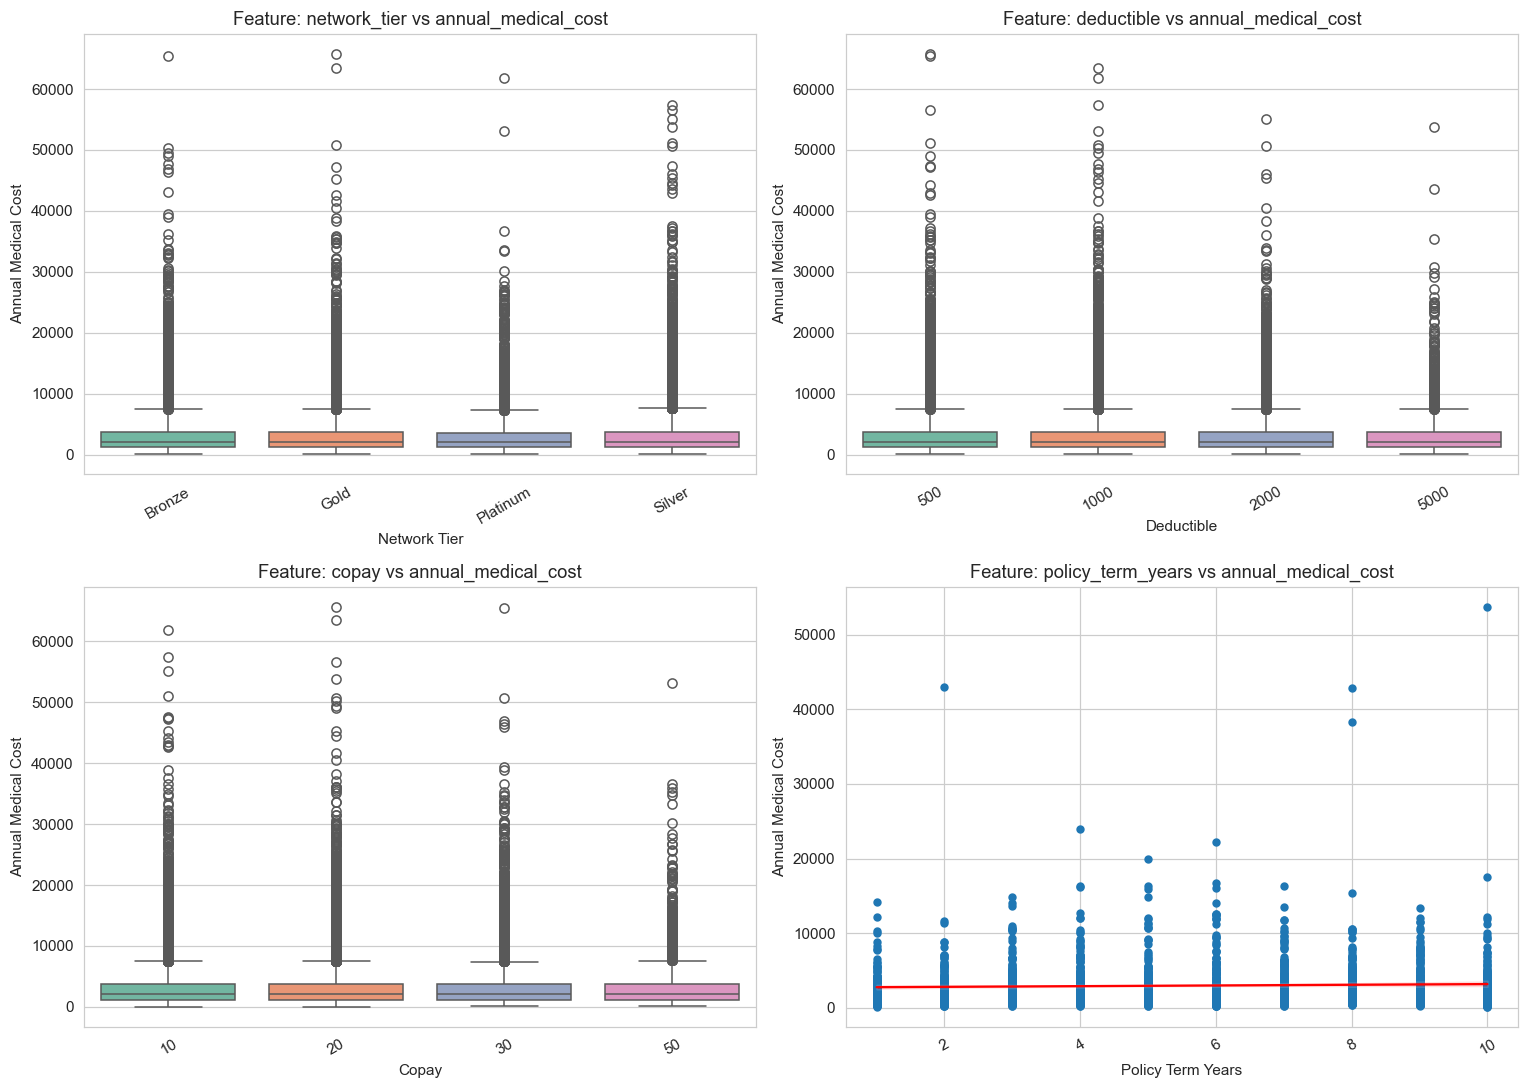

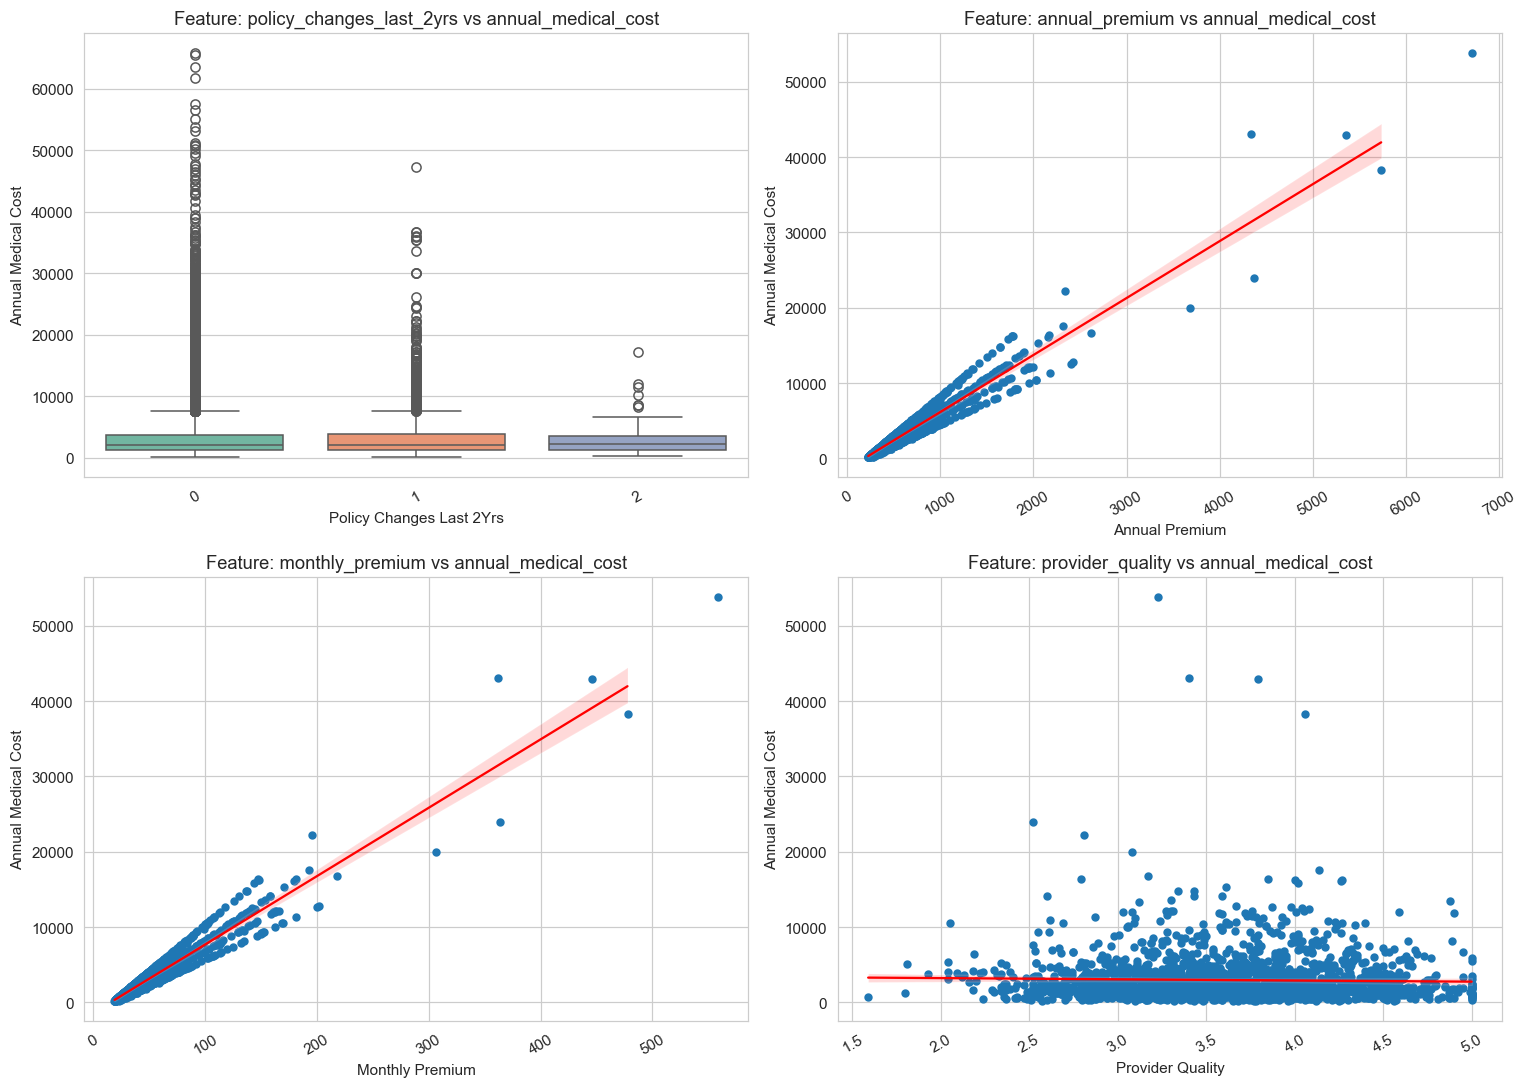

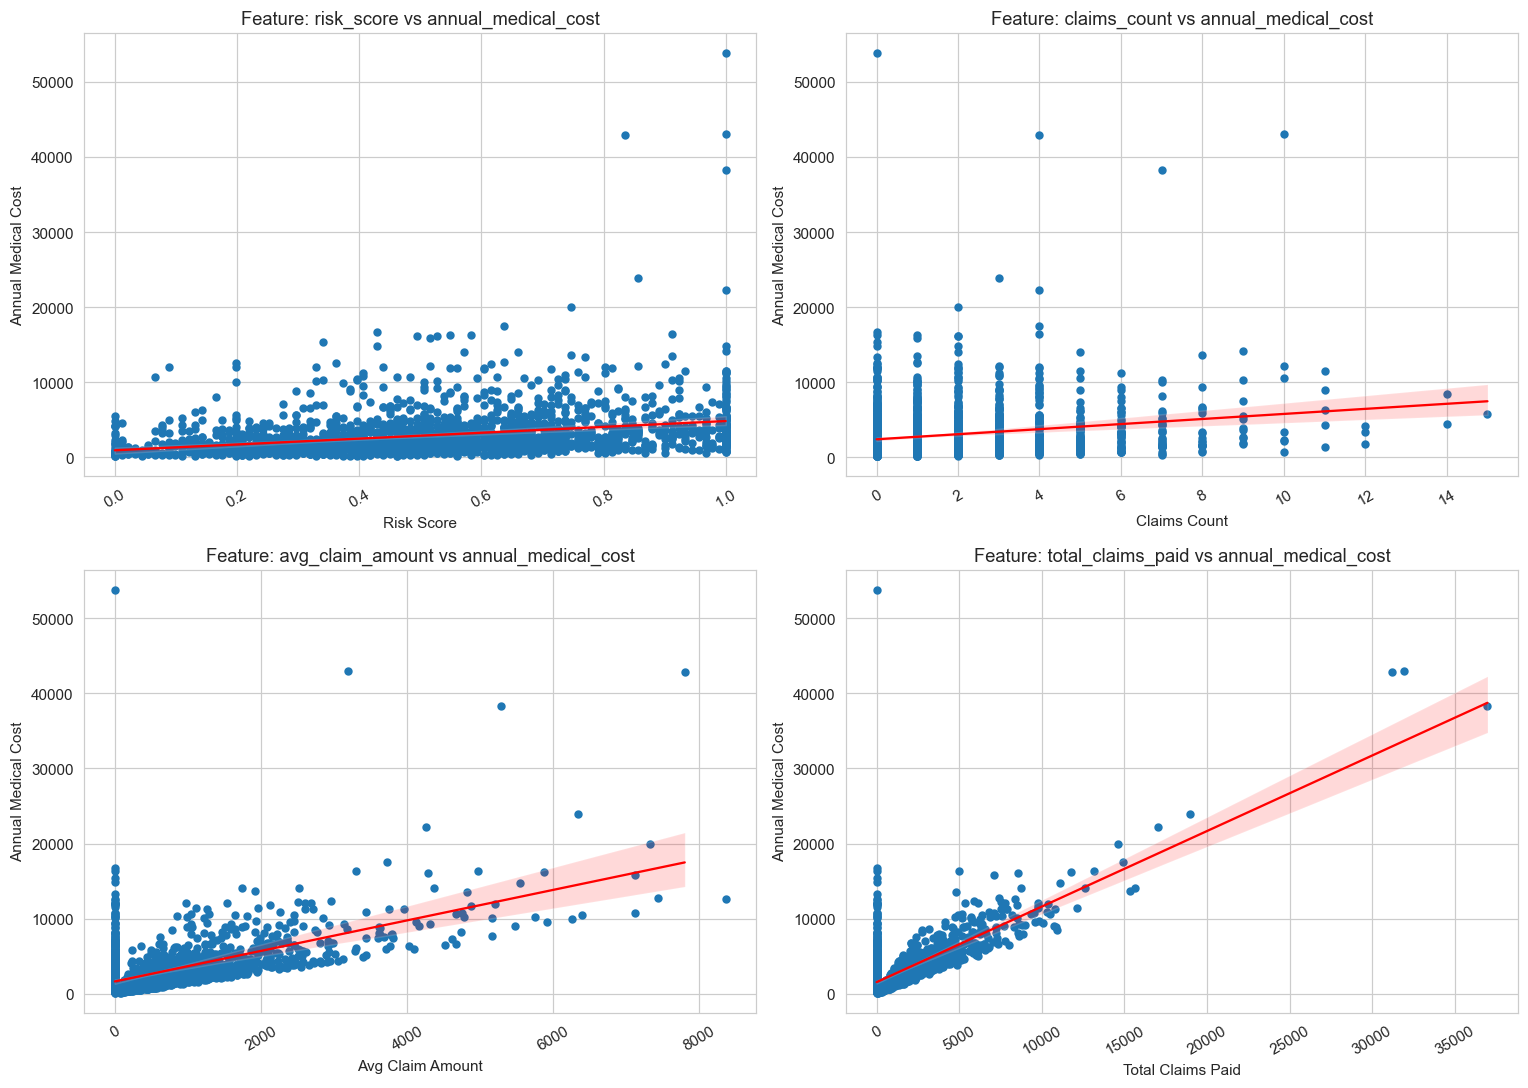

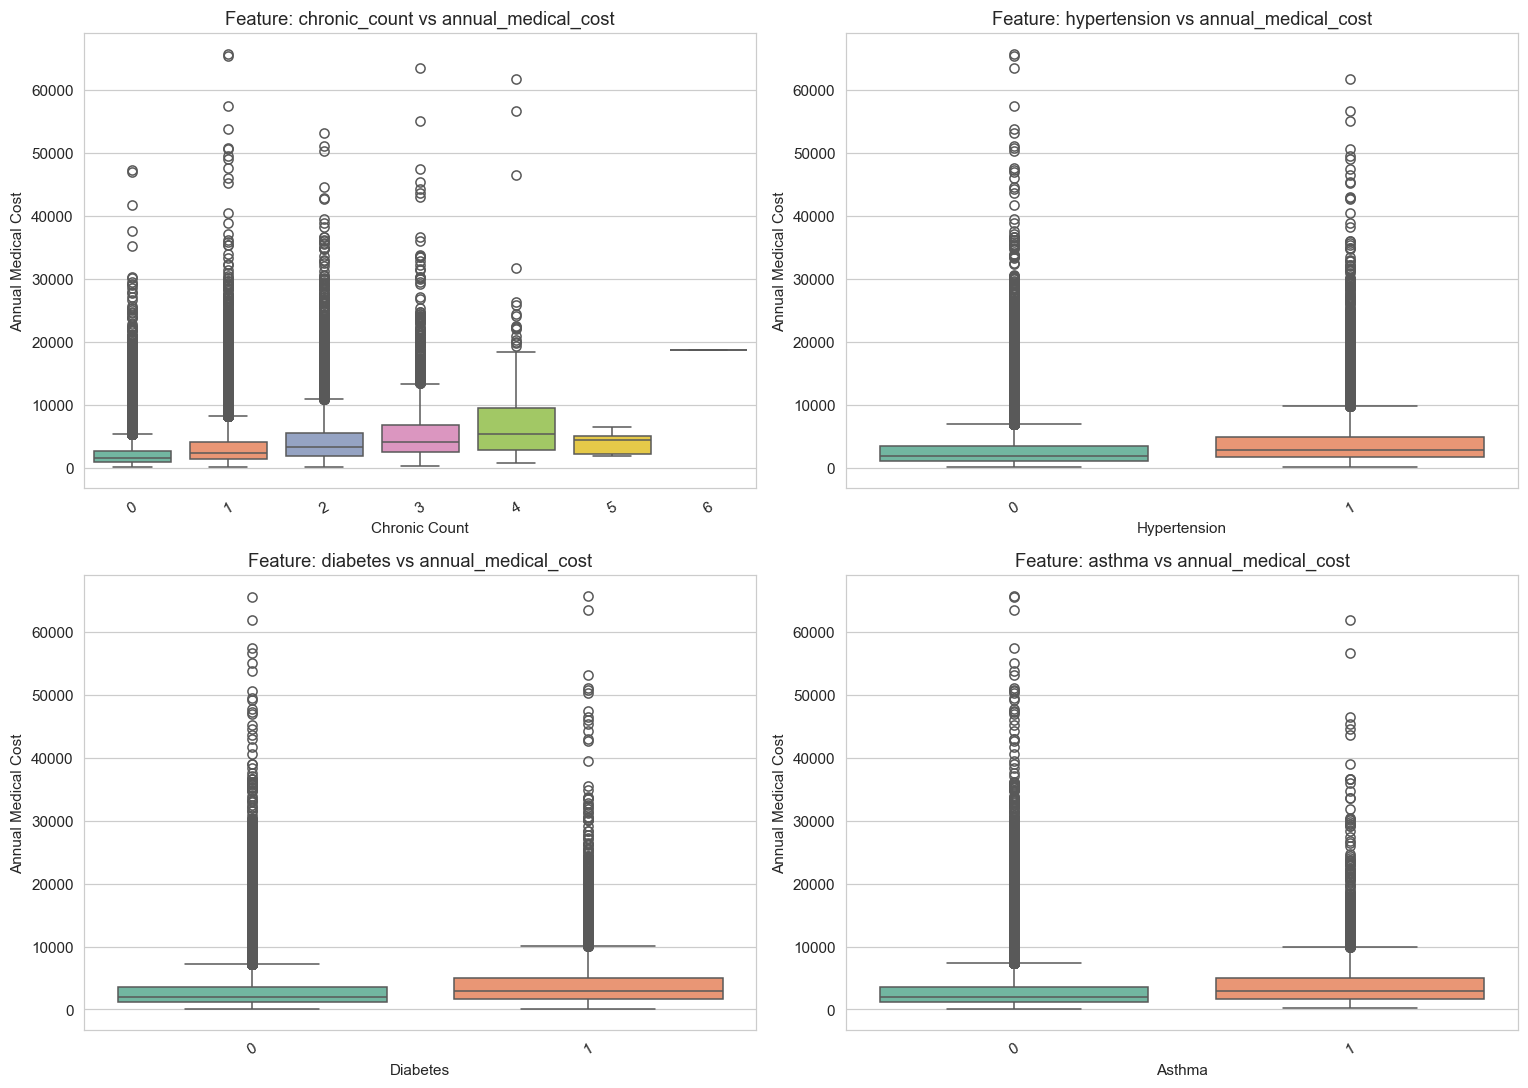

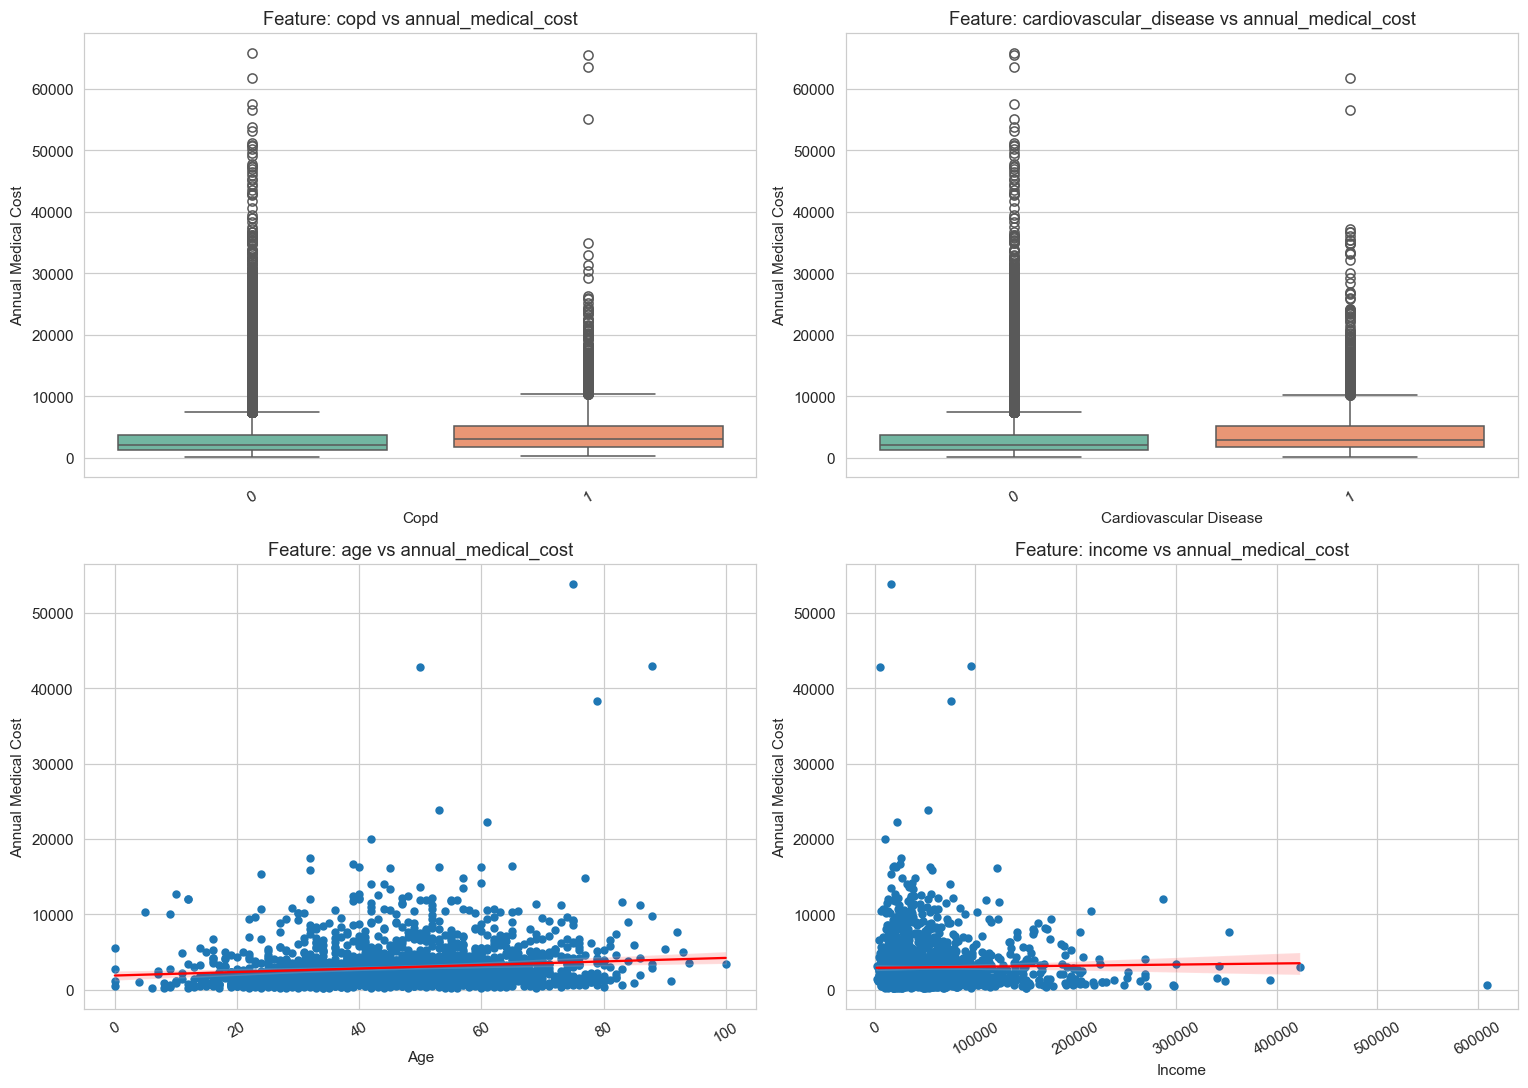

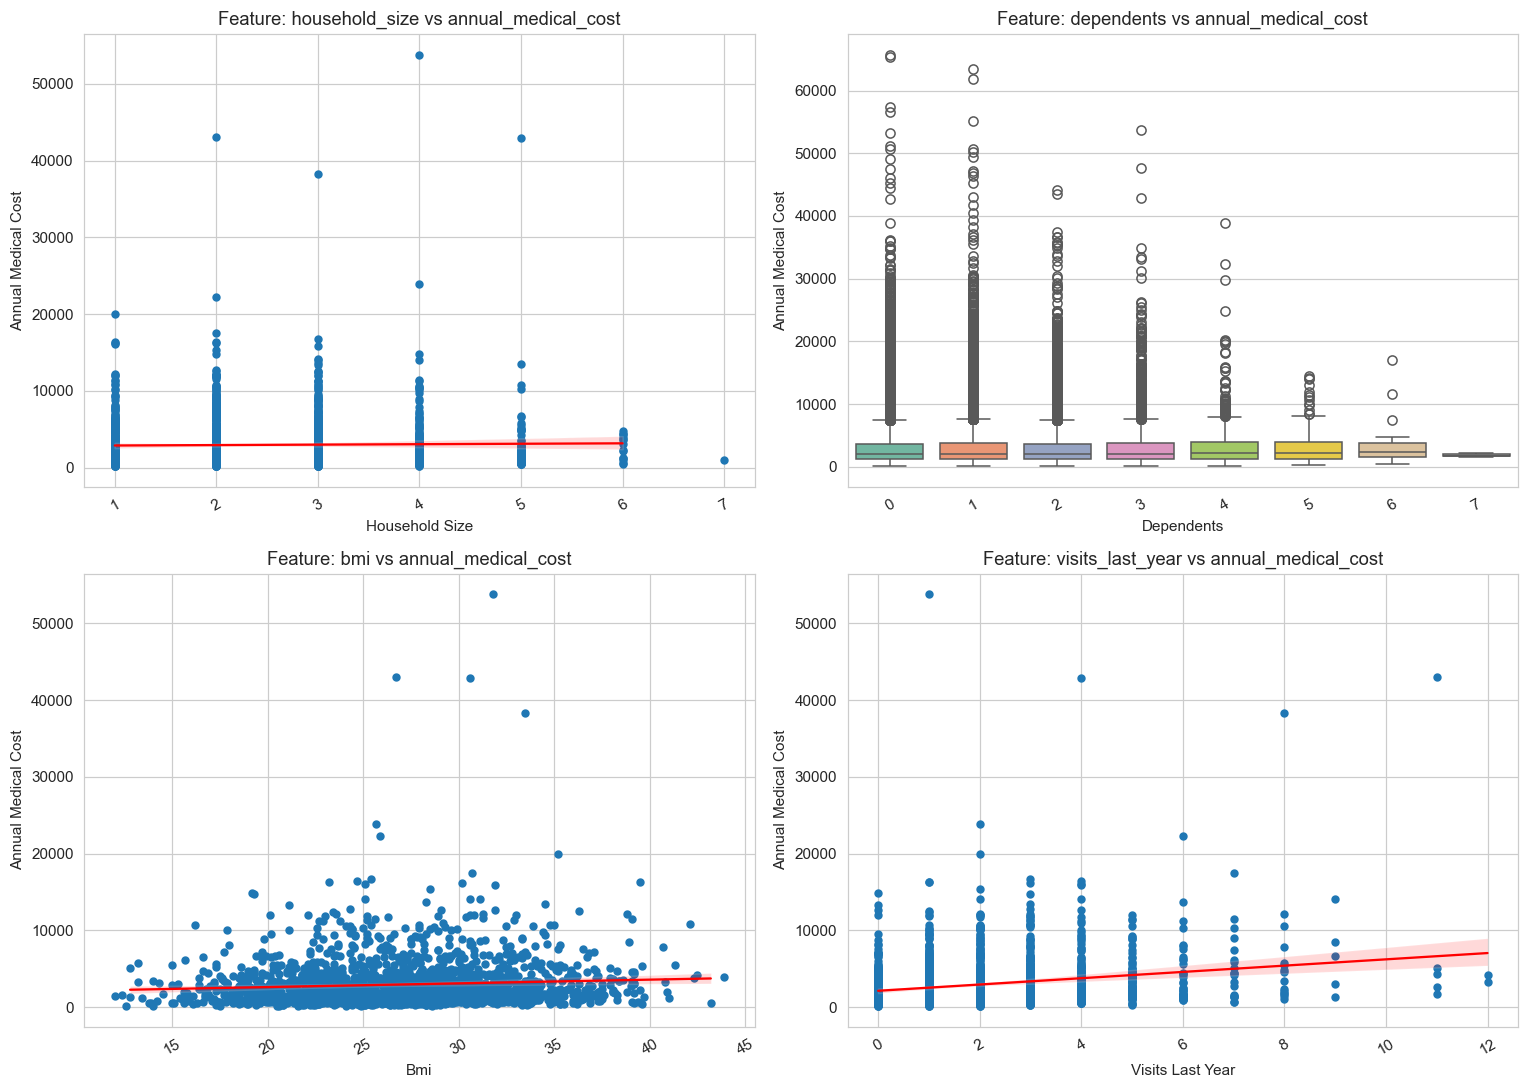

In [ ]:
"""
- One data load
- Unified plotting and analysis style
- Deterministic binary mapping (meaningful)
- Improved smart encoding
- Pearson correlation + significance tests
- RandomForest feature importance (raw features)
- SelectKBest (F-test) using scaled continuous features
- Final scoring & redundancy resolution
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

import warnings
# ---------------------------
# Config
# ---------------------------
DATA_PATH = 'medical_insurance.csv'   # path to your dataset
SHOW_PLOTS = True                     # set False to run without plotting
RANDOM_STATE = 42

warnings.filterwarnings('ignore', category=FutureWarning)

sns.set_style("whitegrid")
plt.rcParams.update({'figure.dpi': 110})

# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv(DATA_PATH)
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns\n")

# ---------------------------
# Column setup
# ---------------------------
target = 'annual_medical_cost'

candidate_features = [
    # Clinical / procedures
    "cancer_history", "kidney_disease", "liver_disease", "arthritis", "mental_health",
    "proc_imaging_count", "proc_surgery_count", "proc_physio_count", "proc_consult_count", "proc_lab_count",
    "is_high_risk", "had_major_procedure",

    # Hospitalization & vitals
    "hospitalizations_last_3yrs", "days_hospitalized_last_3yrs", "medication_count",
    "systolic_bp", "diastolic_bp", "ldl", "hba1c",

    # Plan / financial policy
    "plan_type", "network_tier", "deductible", "copay", "policy_term_years", "policy_changes_last_2yrs",
    "annual_premium", "monthly_premium", "premium_ratio", "monthly_premium_ratio",

    # Provider & risk
    "provider_quality", "risk_score",

    # Claims & payments
    "claims_count", "avg_claim_amount", "total_claims_paid",

    # Chronic conditions
    "chronic_count", "hypertension", "diabetes", "asthma", "copd", "cardiovascular_disease",

    # Demographics / socioeconomics
    "age", "income", "household_size", "dependents", "bmi", "visits_last_year",
    "sex", "region", "urban_rural", "education", "marital_status", "employment_status",
    "smoker", "alcohol_freq"
]

# keep only those present in the dataset
candidate_features = [c for c in candidate_features if c in df.columns]
print(f"Candidate features present in data: {len(candidate_features)}\n")

# ---------------------------
# Create ratio features if possible (before encoding)
# ---------------------------
if 'annual_premium' in df.columns and target in df.columns:
    # avoid division by zero
    df['premium_ratio'] = df['annual_premium'] / df[target].replace({0: np.nan})
if 'monthly_premium' in df.columns and target in df.columns:
    df['monthly_premium_ratio'] = df['monthly_premium'] / df[target].replace({0: np.nan})

# refresh candidate features in case those were newly created
candidate_features = [c for c in candidate_features if c in df.columns]

# ---------------------------
# Plotting helper (optimized)
# ---------------------------
def _is_binary_like(series):
    """Detect columns that are binary-like for deterministic meaningful mapping."""
    vals = series.dropna().unique()
    if len(vals) != 2:
        return False
    # if values are boolean dtype
    if pd.api.types.is_bool_dtype(series):
        return True
    # check common representations
    lower = [str(v).strip().lower() for v in vals]
    binary_tokens = set(['yes','no','y','n','true','false','t','f','male','female','m','f','1','0'])
    return any(tok in binary_tokens for tok in lower)


def meaningful_binary_map(val):
    """Map common binary values to meaningful 0/1 where positive/risky = 1.
    This function is robust to capitalization and typical tokens.
    If an unseen token is provided, fallback to alphabetical mapping.
    """
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    # positive / risky tokens
    if s in {'yes','y','true','t','1','smoker','current','male','m','high','risk','positive'}:
        return 1
    if s in {'no','n','false','f','0','non-smoker','female','fem','low','healthy','negative'}:
        return 0
    # numeric strings
    if s.isdigit():
        if s in {'1'}:
            return 1
        if s in {'0'}:
            return 0
    # fallback: alphabetical deterministic
    return 1 if s > '' and s >= 'm' else 0


def smart_encode_column(series):
    """Improved encoding strategy with deterministic behavior.

    - Binary-like (meaningful) -> meaningful_binary_map
    - Small cardinality (3-6) -> ordinal mapping (sorted)
    - Medium cardinality (7-15) -> one-hot (get_dummies)
    - Large cardinality (>15) -> factorize
    """
    uniq = series.dropna().unique()
    n_unique = len(uniq)

    # If boolean or binary-like, use meaningful mapping
    if n_unique == 2 or _is_binary_like(series):
        mapped = series.map(lambda v: meaningful_binary_map(v))
        return pd.DataFrame({series.name: mapped})

    # small categorical -> ordinal
    if n_unique <= 6:
        # sort deterministically
        try:
            sorted_vals = sorted(uniq, key=lambda x: (str(x).lower()))
        except Exception:
            sorted_vals = list(uniq)
        mapping = {val: idx for idx, val in enumerate(sorted_vals)}
        return series.map(mapping).to_frame()

    # medium cardinality -> one-hot
    if n_unique <= 15:
        return pd.get_dummies(series, prefix=series.name, drop_first=False)

    # large cardinality -> factorize
    codes, uniques = pd.factorize(series)
    return pd.DataFrame({series.name: codes})


def plot_batch(df_local, cols, title_prefix="", show=SHOW_PLOTS, ncols=2, figsize=(14,10)):
    if not show:
        return

    n = len(cols)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(cols):
        ax = axes[i]
        try:
            # categorical -> boxplot (use seaborn)
            if df_local[col].dtype == 'O' or df_local[col].nunique() <= 8:
                sns.boxplot(
                    x=col, y=target, data=df_local, ax=ax,
                    hue=None, palette="Set2", dodge=False
                )
            else:
                # numeric -> matplotlib scatter (translucent blue) + seaborn regplot for line
                df_sample = df_local.sample(min(len(df_local), 2000), random_state=RANDOM_STATE)
                ax.scatter(df_sample[col], df_sample[target], s=20)
                # regression line using seaborn (scatter turned off, solid red)
                try:
                   sns.regplot(
                        x=col, y=target,
                        data=df_sample.sample(min(len(df_sample), 1000), random_state=RANDOM_STATE),
                        scatter=False, ax=ax,
                        line_kws={'linewidth':1.5, 'color':'red'}
                    )
                except Exception:
                    # fallback: simple numpy polyfit
                    clean = df_sample[[col, target]].dropna()
                    if len(clean) > 1:
                        coeffs = np.polyfit(clean[col].astype(float), clean[target].astype(float), 1)
                        xs = np.linspace(clean[col].min(), clean[col].max(), 100)
                        ax.plot(xs, coeffs[0]*xs + coeffs[1], color='red', linewidth=1.5)

            ax.set_xlabel(col.replace('_', ' ').title())
            ax.set_ylabel('Annual Medical Cost')
            ax.set_title(f"{title_prefix}{col} vs {target}")
            ax.tick_params(axis='x', rotation=30)

        except Exception as e:
            ax.text(0.5, 0.5, f"Error plotting {col}\n{e}", ha='center', va='center')
            ax.set_axis_off()

    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# ---------------------------
# Summary (EDA)
# ---------------------------
print("DATA SUMMARY (selected):")
print(df[[target] + candidate_features].describe(include='all').transpose().head(10))
print("\nMissing values per selected column (top 20):")
print(df[[target] + candidate_features].isnull().sum().sort_values(ascending=False).head(20))
print("\n")

# ---------------------------
# Batch plotting
# ---------------------------
batch_size = 4
for i in range(0, len(candidate_features), batch_size):
    batch = candidate_features[i:i+batch_size]
    #print(f"Plotting batch {i//batch_size + 1}: {batch}")
    plot_batch(df, batch, title_prefix="Feature: ")

special_blocks = [
    [c for c in ['claims_count', 'avg_claim_amount', 'total_claims_paid', 'annual_premium'] if c in df.columns],
    [c for c in ['chronic_count', 'hypertension', 'diabetes', 'asthma'] if c in df.columns]
]
for blk in special_blocks:
    if blk:
        plot_batch(df, blk, title_prefix="Block: ", figsize=(12,8))

# ---------------------------
# Encoding (Deterministic hybrid)
# ---------------------------
df_enc = df[[target] + candidate_features].copy()

encoded_parts = []
for col in df_enc.columns:
    if col == target:
        encoded_parts.append(df_enc[[col]])
        continue

    # numeric -> keep as-is
    if np.issubdtype(df_enc[col].dtype, np.number):
        encoded_parts.append(df_enc[[col]])
        continue

    # otherwise encode
    encoded = smart_encode_column(df_enc[col])
    if isinstance(encoded, pd.DataFrame):
        encoded_parts.append(encoded)
    else:
        encoded_parts.append(pd.DataFrame({col: encoded}))

# combine
df_enc = pd.concat(encoded_parts, axis=1)

# create ratios again in encoded df if we added columns after initial build
if 'annual_premium' in df.columns and target in df.columns and 'premium_ratio' not in df_enc.columns:
    df_enc['premium_ratio'] = df['annual_premium'] / df[target].replace({0: np.nan})
if 'monthly_premium' in df.columns and target in df.columns and 'monthly_premium_ratio' not in df_enc.columns:
    df_enc['monthly_premium_ratio'] = df['monthly_premium'] / df[target].replace({0: np.nan})

print("\nEncoding complete. Encoded columns:", df_enc.shape[1])



# ---------------------------
# Correlation matrix
# ---------------------------
corr_df = df_enc.dropna(axis=1, how='all').loc[:, df_enc.nunique() > 1].corr()

if SHOW_PLOTS:
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_df, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.4)
    plt.title("Correlation Matrix (encoded)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Identify columns used in correlation matrix
included_cols = set(corr_df.columns)
all_cols = set(df_enc.columns)

# Columns dropped from correlation calculation
missing_from_corr = all_cols - included_cols

print("⚠️ Columns not included in correlation matrix:")
if not missing_from_corr:
    print("✅ All columns were included.")
else:
    for col in missing_from_corr:
        reason = []
        if df_enc[col].isna().all():
            reason.append("all NaN")
        elif df_enc[col].nunique() <= 1:
            reason.append("constant / only one unique value")
        elif not np.issubdtype(df_enc[col].dtype, np.number):
            reason.append(f"non-numeric ({df_enc[col].dtype})")
        else:
            reason.append("unknown reason")
        print(f"  - {col}: {', '.join(reason)}")

# ---------------------------
# Target correlation
# ---------------------------
if target not in corr_df.columns:
    raise ValueError(f"Target column '{target}' not found in correlation matrix. Check data.")

target_corr = corr_df[target].drop(target).sort_values(ascending=False)
print("TOP FEATURES BY PEARSON CORRELATION WITH TARGET:")
print(target_corr.head(15))
print()

# ---------------------------
# Pearson significance
# ---------------------------
significant_features = []
for feat in target_corr.index:
    try:
        x = df_enc[feat].dropna()
        y = df_enc.loc[x.index, target]
        common_index = x.index.intersection(y.index)
        if len(common_index) < 10:
            continue
        corr_coef, p_val = pearsonr(x.loc[common_index], y.loc[common_index])
        if not np.isnan(p_val) and p_val < 0.05:
            significant_features.append((feat, corr_coef, p_val))
    except Exception:
        continue

significant_features = sorted(significant_features, key=lambda x: abs(x[1]), reverse=True)
print("STATISTICALLY SIGNIFICANT PEARSON CORRELATIONS (p < 0.05):")
for feat, coef, p in significant_features[:20]:
    print(f"{feat:30s} | r = {coef:6.3f} | p = {p:.4g}")
print()

# ---------------------------
# Multicollinearity
# ---------------------------
high_corr_pairs = []
cols_corr = corr_df.columns.tolist()
for i in range(len(cols_corr)):
    for j in range(i+1, len(cols_corr)):
        if cols_corr[i] == target or cols_corr[j] == target:
            continue
        val = corr_df.iloc[i, j]
        if abs(val) > 0.75:
            high_corr_pairs.append((cols_corr[i], cols_corr[j], val))

if high_corr_pairs:
    print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.75):")
    for a, b, v in high_corr_pairs:
        print(f"{a:25s} <--> {b:25s} : {v:6.3f}")
else:
    print("No very high feature-feature correlations found (threshold 0.75).")
print()

# ---------------------------
# Prepare modeling dataset (drop rows with NA for model features)
# ---------------------------
model_features = [c for c in df_enc.columns if c != target]
# drop columns that are completely non-numeric just in case
numeric_model_features = [c for c in model_features if np.issubdtype(df_enc[c].dtype, np.number)]

# create modeling dataframe (drop rows with NA in selected numeric features + target)
df_model = df_enc[[target] + numeric_model_features].dropna(axis=0, how='any').copy()

print("Modeling dataset size (after dropna):", df_model.shape)

X = df_model[numeric_model_features]
y = df_model[target]

# ---------------------------
# RandomForest (use raw numeric features)
# ---------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X, y)
rf_importances = pd.DataFrame({
    'feature': numeric_model_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\nRANDOM FOREST FEATURE IMPORTANCE (top 15):")
print(rf_importances.head(15).to_string(index=False))

# ---------------------------
# SelectKBest (F-test) using scaled continuous features
# ---------------------------
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_scaled, y)
feature_scores = pd.DataFrame({
    'feature': X.columns,
    'f_score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('f_score', ascending=False).reset_index(drop=True)

print("\nSELECTKBEST (F-test) SCORES (top 15):")
print(feature_scores.head(15).to_string(index=False))

# ---------------------------
# Combined scoring (heuristic)
# ---------------------------
feature_summary = {}
for feat in numeric_model_features:
    score = 0
    corr_val = abs(target_corr.get(feat, 0.0))
    if corr_val > 0.25:
        score += 3
    elif corr_val > 0.10:
        score += 2
    elif corr_val > 0.05:
        score += 1

    p_row = feature_scores[feature_scores['feature'] == feat]
    if not p_row.empty:
        p_val = float(p_row['p_value'].iloc[0])
        if p_val < 0.001:
            score += 3
        elif p_val < 0.01:
            score += 2
        elif p_val < 0.05:
            score += 1

    rf_idx = rf_importances[rf_importances['feature'] == feat].index
    if len(rf_idx) > 0:
        rf_rank = int(rf_idx[0])
        if rf_rank < 3:
            score += 2
        elif rf_rank < 6:
            score += 1

    feature_summary[feat] = score

final_scores = sorted(feature_summary.items(), key=lambda x: x[1], reverse=True)

print("\nFINAL FEATURE RANKING (heuristic score):")
print(f"{'Rank':>4} | {'Feature':30s} | {'Score':>5} | Recommendation")
for i, (feat, sc) in enumerate(final_scores, 1):
    rec = "KEEP" if sc >= 5 else ("KEEP (consider)" if sc >= 3 else "DROP / LOW")
    print(f"{i:4d} | {feat:30s} | {sc:5d} | {rec}")

# ---------------------------
# Redundancy cleanup
# ---------------------------
redundant_drops = set()
for a, b, val in high_corr_pairs:
    corr_a = abs(target_corr.get(a, 0.0))
    corr_b = abs(target_corr.get(b, 0.0))
    if corr_a >= corr_b:
        keep, drop = a, b
    else:
        keep, drop = b, a
    redundant_drops.add(drop)
    print(f"REDUNDANCY: KEEP {keep:30s} | DROP {drop:30s} (pair corr={val:0.3f})")

if redundant_drops:
    print("\nFinal suggested drops due to redundancy:")
    for d in redundant_drops:
        print(" -", d)
else:
    print("\nNo redundancy-based drops suggested.")

# ---------------------------
# Final selected features
# ---------------------------
selected_features = [feat for feat, score in final_scores if score >= 3 and feat not in redundant_drops]
print(f"\nFINAL SELECTED FEATURES ({len(selected_features)}):")
for f in selected_features:
    print(" -", f)

# ---------------------------
# Summary
# ---------------------------
print("\n=== SUMMARY ===")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Modeling rows used (after dropna): {df_model.shape[0]}")
print(f"Top RF feature: {rf_importances.iloc[0]['feature'] if not rf_importances.empty else 'N/A'}")
print("Top correlated features (abs r):")
for f, v in list(target_corr.abs().items())[:8]:
    print(f" - {f}: {v:0.3f}")

print("\nScript complete. Adjust SHOW_PLOTS at top to suppress plots when needed.")
